<a href="https://colab.research.google.com/github/abysse8/F23-Wavelet-Project/blob/main/Modified_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Notebook
This notebook demonstrates the construction and training of a simple convolutional neural network (CNN),
specifically designed for image classification tasks. The network utilizes wavelet transforms and explores the impact of
varying sparsity levels on model performance. The code includes model definition, data loading, training, and visualization of results.

TO INSTALL

pip install torch torchvision torchaudio

pip install pywavelets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pywt  # PyWavelets for wavelet transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from math import ceil  # Used in the SimpleCNN class

In [2]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

# Test CUDA operation
if torch.cuda.is_available():
    x = torch.tensor([1.0, 2.0])
    print("Original Device:", x.device)
    x = x.to("cuda")
    print("New Device:", x.device)
else:
    print("CUDA is not available.")


PyTorch Version: 2.1.0+cu118
CUDA Available: True
Original Device: cpu
New Device: cuda:0


In [3]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

class SimpleCNN(nn.Module):
    def __init__(self, sparse=1, num_classes=47):
        super(SimpleCNN, self).__init__()
        if sparse <= 0:
            raise ValueError("Sparse value must be greater than 0")
        self.conv1 = nn.Conv2d(3, max(1, ceil(32 * sparse)), kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(max(1, ceil(32 * sparse)), max(1, ceil(64 * sparse)), kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        size_after_pooling = 128 // 2 // 2
        flattened_size = max(1, ceil(64 * sparse)) * size_after_pooling * size_after_pooling

        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
def to_wavelet_coeffs(data, wavelet='db1', mode='symmetric'):
    coeffs = pywt.wavedec2(data, wavelet=wavelet, mode=mode, level=1)
    # Take only the first level decomposition
    cA, (cH, cV, cD) = coeffs
    # Stack coefficients in a single tensor (you can also experiment with other ways of combining these)
    coeffs_tensor = torch.stack([torch.Tensor(cA), torch.Tensor(cH), torch.Tensor(cV), torch.Tensor(cD)])
    return coeffs_tensor

# Custom Dataset class
class WaveletDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Convert image to numpy array and apply wavelet transform
        image_array = np.array(image)
        wavelet_coeffs = to_wavelet_coeffs(image_array)
        return wavelet_coeffs, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

dtd = torchvision.datasets.DTD(root='./data', download=True, transform=transform)

# Define a subset of the dataset
subset_indices = np.random.choice(len(dtd), 50, replace=False) # Adjust 1000 to the number of samples you want
dtd_train_subset = Subset(dtd, subset_indices)

# Create wavelet transformed datasets
wavelet_train_subset = WaveletDataset(dtd_train_subset)

# DataLoader for the subset
train_loader_subset = DataLoader(wavelet_train_subset, batch_size=20, shuffle=True)

100%|██████████| 625239812/625239812 [00:22<00:00, 27314895.29it/s]


Extracting data/dtd/dtd-r1.0.1.tar.gz to data/dtd


In [ ]:
y = next(iter(train_loader_subset))[0]
x, lab = next(iter(train_loader_subset))
y.shape, x.shape

In [ ]:
def wavelet_display(decomped):
    plt.imshow(torch.concat((torch.concat((decomped[0],decomped[1]), dim=-1), torch.concat((decomped[2],decomped[3]), dim=-1)), dim=-2))

wavelet_display(x[0,:,0])

In [18]:
def train_model(model, sum_deets, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        total = 0
        correct = 0
        epoch_loss = 0.0

        for inputs, labels in train_loader_subset:
            if sum_deets == 'sum':
                inputs = inputs[:,0].to(device)
            elif sum_deets == 'deets':
                inputs = inputs[:,1]+inputs[:,2]+inputs[:,3]
                inputs = inputs.to(device)

            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        loss_history.append(epoch_loss / total)
        accuracy_history.append(100 * correct / total)

    return loss_history, accuracy_history


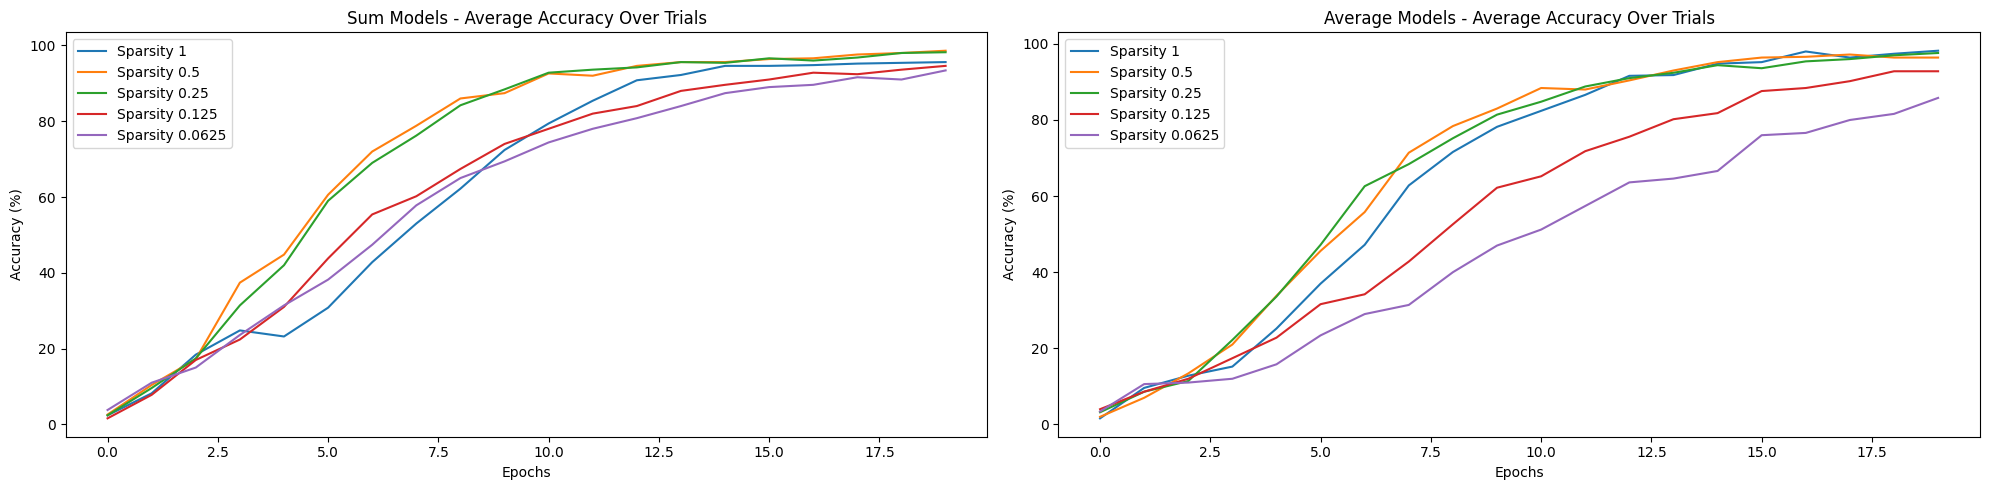

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim

epochs = 20
num_trials = 10

fig, (ax_sum, ax_avg) = plt.subplots(1, 2, figsize=(20, 5))

for sparsity_index in [1, 0.5, 0.25, 0.125, 0.0625]:
    all_accuracies_sum = []
    all_accuracies_avg = []

    for trial in range(num_trials):
        model_sum = SimpleCNN(sparsity_index).to(device)
        model_avg = SimpleCNN(sparsity_index).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer_sum = torch.optim.Adam(model_sum.parameters(), lr=0.001)
        optimizer_avg = torch.optim.Adam(model_avg.parameters(), lr=0.001)

        _, accuracy_history_sum = train_model(model_sum, 'sum', criterion, optimizer_sum, epochs=epochs)
        _, accuracy_history_avg = train_model(model_avg, 'deets', criterion, optimizer_avg, epochs=epochs)

        all_accuracies_sum.append(accuracy_history_sum)
        all_accuracies_avg.append(accuracy_history_avg)

    avg_accuracy_history_sum = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_sum)]
    avg_accuracy_history_avg = [sum(epoch_accuracies) / num_trials for epoch_accuracies in zip(*all_accuracies_avg)]

    ax_sum.plot(avg_accuracy_history_sum, label=f'Sparsity {sparsity_index}')
    ax_avg.plot(avg_accuracy_history_avg, label=f'Sparsity {sparsity_index}')

ax_sum.set_xlabel('Epochs')
ax_sum.set_ylabel('Accuracy (%)')
ax_sum.set_title('Sum Models - Average Accuracy Over Trials')
ax_sum.legend()

ax_avg.set_xlabel('Epochs')
ax_avg.set_ylabel('Accuracy (%)')
ax_avg.set_title('Average Models - Average Accuracy Over Trials')
ax_avg.legend()

plt.tight_layout()
plt.show()


In [ ]:
o = model_sum(x[0,0].unsqueeze(0))
o[0,lab[0]-10:lab[0]+10]

In [ ]:
lab[0]

tensor(16)

AttributeError: ignored